# 0. Configuration

In [9]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

# 1. Modules and functions

In [10]:
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import umap.umap_ as umap

import warnings
warnings.filterwarnings('ignore')

# download stop words beforehand
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suanow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.1. Helper functions to avoid copypaste

In [11]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

In [12]:
# init lemmatizer to avoid slow performance
mystem = Mystem() 

def word_tokenize_clean(doc: str, stop_words: list):
    '''
    tokenize from string to list of words
    '''

    # split into lower case word tokens \w lemmatization
    tokens = list(set(mystem.lemmatize(doc.lower())))
  
    # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words \
              not in list(punctuation)]
    return tokens

# 2. Main

## 2.1. Data Preparation

In [13]:
# read csv information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [14]:
# let's see what columns we have
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

To get accurate results we need to preprocess text a bit. The pipeline will be as follows:

- Filter only necessary columns from movies_metadada : id, original_title, overview;
- Define `model_index` for model to match back with `id` column;
- Text cleaning: removing stopwords & punctuation, lemmatization for further tokenization and tagged document creatin required for gensim.Doc2Vec

In [15]:
# filter cols
sample = movies_metadata[['id', 'original_title', 'overview']].copy()
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [16]:
# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.isnull().sum()

id                0
original_title    0
overview          0
dtype: int64

In [17]:
# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

In [18]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [19]:
# preprocess by removing non-character data, stopwords
tags_corpus = sample['overview'].values
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
tags_doc[:1]

[['live',
  'aside',
  'happily',
  'room',
  'afraid',
  'losing',
  'circumstances',
  'buzz',
  'place',
  'andy',
  'plots',
  'heart',
  'eventually',
  'owner',
  'separate',
  'brings',
  'onto',
  'differences',
  'led',
  'scene',
  'lightyear',
  'woody',
  'put',
  'birthday',
  'learns',
  'duo',
  'toys']]

In [20]:
# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [21]:
# let's check what do we have
## tag = movie index
tags_doc[1]

TaggedDocument(words=['peter', 'unwittingly', 'alan', 'inside', 'room', 'find', 'board', 'discover', 'world', 'monkeys', 'proves', 'trapped', 'siblings', 'invite', 'risky', 'three', 'opens', 'giant', 'judy', 'living', 'game', 'rhinoceroses', 'magical', 'enchanted', 'terrifying', 'freedom', 'years', 'evil', 'creatures', 'hope', 'finish', 'adult', 'door', 'running'], tags=['1'])

# 2.2. Model Training and Evaluation

In [22]:
VEC_SIZE = 50
ALPHA = .02
MIN_ALPHA = .00025
MIN_COUNT = 5
EPOCHS = 20

In [23]:
# initialize
model = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

In [24]:
# generate vocab from all tag docs
model.build_vocab(tags_doc)

In [25]:
# train model
model.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

## 2.3. Evaluate the model

Let's assume that we watched movie `batman` and based on that generate recommendation similar to it's description.

To do that we need
- To extract movie id from `movies_inv_mapper` we created to map back titles from model output
- Load embeddings from trained model
- Use built-in most_similar() method to get most relevant recommendations based on film embedding
- Finally, map title names for sense-check

In [26]:
# get id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [27]:
# load trained embeddings 
movies_vectors_1 = model.dv.vectors

In [28]:
movie_embeddings = movies_vectors_1[movie_id]

In [29]:
# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,5713,0.947819
2,7772,0.947441
3,29872,0.945235
4,43461,0.944393


In [30]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [31]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output


,model_index,model_score,title_name
0,8603,1.000000,batman
1,5713,0.947819,rollover
2,7772,0.947441,this island earth
3,29872,0.945235,angels die hard
4,43461,0.944393,megafault
5,26340,0.944045,the siege of firebase gloria
6,24433,0.943327,the creeping terror
7,28001,0.942440,reach me
8,43165,0.942377,the zookeeper's wife
9,13835,0.942233,k2


# TODO

- Add `original_title`, `keywords`, `tagline` and other metadata to train sample and then retrain embeddings;
- Make visualization of embeddings with links of films with each other;
- Compare results with the embeddings we created in lecture
- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

# Appendix

Here, we wrap up all pipeline into functions to re-use if needed and it is just prettier to code this way :)

In [32]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_col = 'tag'):
    '''text preprocessing
    '''
    tags_corpus = agg_tags[text_col].values
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')


    # preprocess corpus of movie tags before feeding it into Doc2Vec model
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc


In [33]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model

# Solution
- Add `title` and `tagline` to sample metadata

In [34]:
sample = movies_metadata[['id', 'original_title', 'overview', 'tagline']].copy()

# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.loc[sample['tagline'].isnull(), 'tagline'] = sample.loc[sample['tagline'].isnull(), 'original_title']


# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

# preprocess by removing non-character data, stopwords
tags_corpus = (sample['overview'].values + ' ' + sample['original_title'].values + ' ' + sample['tagline'].values)
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]

# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

# let's check what do we have
## tag = movie index
tags_doc[1]

model = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

model.build_vocab(tags_doc)

# train model
model.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

# get id
movie_id = movies_inv_mapper['batman']

# load trained embeddings 
movies_vectors = model.dv.vectors

movie_embeddings = movies_vectors[movie_id]

# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output2 = pd.DataFrame(similars, columns = ['model_index', 'model_score'])

# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

output2['title_name'] = output2['model_index'].astype(int).map(name_mapper)
output2

,model_index,model_score,title_name
0,8603,1.000000,batman
1,34637,0.930708,capitães da areia
2,4199,0.926482,NaN
3,43461,0.925865,megafault
4,35181,0.923769,конек-горбунок
5,7628,0.923573,sodom and gomorrah
6,9748,0.923012,NaN
7,40652,0.922340,homeless in america
8,39970,0.922108,ufo... annientare s.h.a.d.o. stop. uccidete st...
9,28001,0.921562,reach me


- Make visualization of embeddings with links of films with each other; 

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


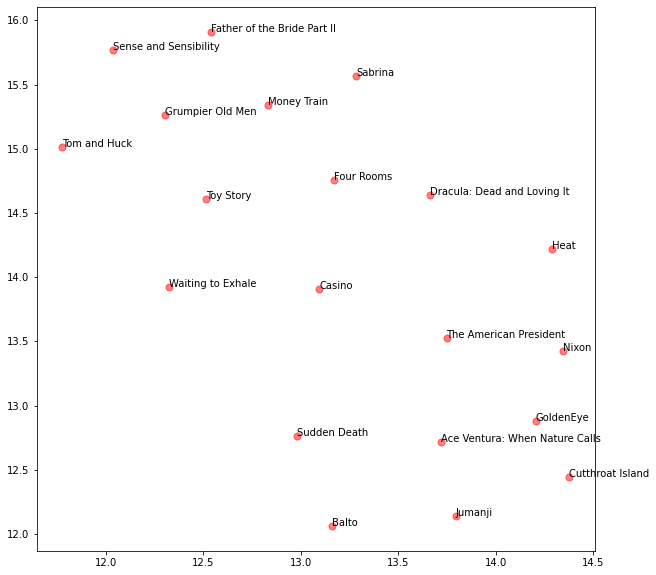

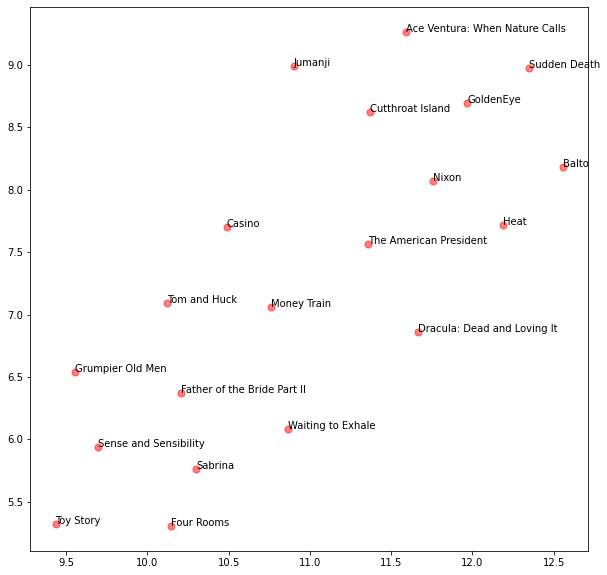

In [35]:
def visualize_movie_embeddings(movie_vectors, movie_titles):
    umap_embeddings = umap.UMAP(n_neighbors=15,
                                n_components=2,
                                min_dist=0.1,
                                metric='correlation').fit_transform(movie_vectors)

    plt.figure(figsize=(10,10))
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=50, alpha=0.5, c='r')
    
    for i, title in enumerate(movie_titles):
        plt.annotate(title, (umap_embeddings[i,0], umap_embeddings[i,1]))
        
    plt.show()


movie_titles = movies_metadata['original_title'].values

visualize_movie_embeddings(movies_vectors_1[:20], movie_titles[:20]) # lecture 
visualize_movie_embeddings(movies_vectors[:20], movie_titles[:20]) # hw

We can see, that the distribution changed. Lecture output is has a "falling" trend, and hw output has "rising" trend

- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

In [36]:
def get_recommendations(movie_titles: list) -> pd.DataFrame:
    """
    Takes a list of movie titles and returns recommendations based on the combined embeddings.
    :movie_titles: List of movie titles.
    """
    
    indices = [movies_inv_mapper[title.lower()] for title in movie_titles if title.lower() in movies_inv_mapper]

    if not indices:
        print('Please send valid titles')
        return

    movie_embeddings = np.mean(movies_vectors[indices], axis=0)
    similars = model.docvecs.most_similar(positive=[movie_embeddings], topn=20)
    recommendation = pd.DataFrame(similars, columns=['model_index', 'model_score'])

    recommendation['title_name'] = output['model_index'].astype(int).map(name_mapper)

    return recommendation


In [38]:
get_recommendations(['batman', 'megafault', 'k2'])

,model_index,model_score,title_name
0,13835,0.978149,batman
1,43461,0.974564,rollover
2,8603,0.973368,this island earth
3,35181,0.969575,angels die hard
4,44339,0.967639,megafault
5,6101,0.963982,the siege of firebase gloria
6,39970,0.961660,the creeping terror
7,3536,0.960145,reach me
8,10406,0.957285,the zookeeper's wife
9,18740,0.956330,k2
